In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import classification_report
import precision_recall_cutoff

### defining bucket###
s3=boto3.resource('s3')
bucket_name= 'dmw-448'
bucket = s3.Bucket(bucket_name)

### definging CSV ###
file_key = 'train.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')


# Reading the csv file and seperating columkns
train = pd.read_csv(file_content_stream, sep = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [3]:
# Defining the file to be read from s3 bucket
file_key = "test.csv"

bucket_object1 = bucket.Object(file_key)
file_object1 = bucket_object1.get()
file_content_stream = file_object1.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream, sep = '|')
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


[Text(697.5, 713.475, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(348.75, 509.625, 'lineItemVoidsPerPosition <= 0.512\ngini = 0.396\nsamples = 265\nvalue = [193, 72]'),
 Text(174.375, 305.775, 'lineItemVoids <= 7.5\ngini = 0.482\nsamples = 175\nvalue = [104, 71]'),
 Text(87.1875, 101.92499999999995, 'gini = 0.418\nsamples = 131\nvalue = [92, 39]'),
 Text(261.5625, 101.92499999999995, 'gini = 0.397\nsamples = 44\nvalue = [12, 32]'),
 Text(523.125, 305.775, 'grandTotal <= 89.925\ngini = 0.022\nsamples = 90\nvalue = [89, 1]'),
 Text(435.9375, 101.92499999999995, 'gini = 0.0\nsamples = 82\nvalue = [82, 0]'),
 Text(610.3125, 101.92499999999995, 'gini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(1046.25, 509.625, 'grandTotal <= 98.455\ngini = 0.018\nsamples = 1238\nvalue = [1227, 11]'),
 Text(871.875, 305.775, 'trustLevel <= 2.5\ngini = 0.013\nsamples = 1215\nvalue = [1207, 8]'),
 Text(784.6875, 101.92499999999995, 'gini = 0.058\nsamples = 267\nvalue = [259

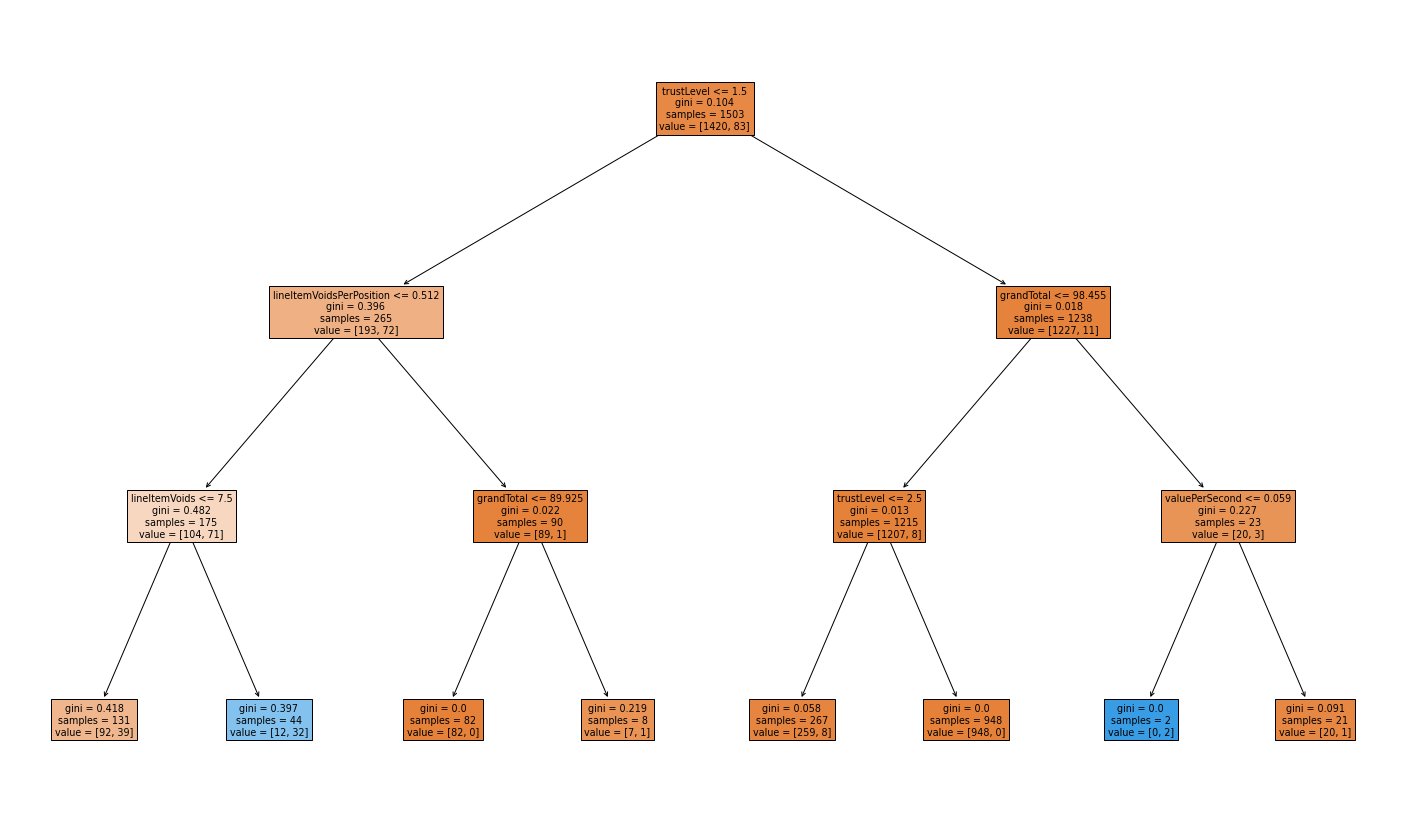

In [32]:
## definging input and target variables
X = train.drop(columns = ['fraud'], axis = 1)
Y = train['fraud']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## buildong decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## visualization
fig = plt.figure(figsize = (25,15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

## Used the chart above because it has four 3 levels of 

In [34]:
## creating interaction
train['interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] <= 0.512) & (train['lineItemVoids'] <= 7.5), 1, 0)
train['interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] >= 0.512) & (train['totalScanTimeInSeconds'] >= 1601.5), 1, 0)
train['interaction_3'] = np.where((train['trustLevel'] >= 1.5) & (train['grandTotal'] <= 98.455) & (train['valuePerSecond'] <= 0.059), 1, 0)

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,1
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,1
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,1
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0


In [35]:
## Defining the input and target variables
X = train.drop(columns = ['fraud', 'grandTotal'], axis = 1)
Y = train['fraud']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

X_train.head()

,trustLevel,totalScanTimeInSeconds,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,interaction_1,interaction_2,interaction_3
488,3,1705,0,6,2,0.002346,0.042129,0.000000,0,0,1
867,2,374,6,2,2,0.024064,0.136524,0.666667,0,0,0
1251,1,1246,1,9,4,0.014446,0.050249,0.055556,1,0,0
869,6,1352,2,6,2,0.017012,0.024578,0.086957,0,0,1
791,5,1593,10,3,5,0.017577,0.039385,0.357143,0,0,1


In [36]:
## Random forest 
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on test
RF_pred = RF.predict_proba(X_test)[:, 1]

## Predicting the labels
RF_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, RF_pred)

## Computing the classification report
print(classification_report(Y_test, RF_labels))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.64      0.76      0.70        21

    accuracy                           0.96       376
   macro avg       0.81      0.87      0.84       376
weighted avg       0.97      0.96      0.96       376



In [37]:
## removing interactions
X_train = X_train.drop(columns = ['interaction_1', 'interaction_2', 'interaction_3'], axis = 1)
X_test = X_test.drop(columns = ['interaction_1', 'interaction_2', 'interaction_3'], axis = 1)

## Random forest 
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on test
RF_pred = RF.predict_proba(X_test)[:, 1]

## Predicting the labels
RF_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, RF_pred)

## Computing the classification report
print(classification_report(Y_test, RF_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       355
           1       0.73      0.76      0.74        21

    accuracy                           0.97       376
   macro avg       0.86      0.87      0.86       376
weighted avg       0.97      0.97      0.97       376



In [ ]:
## defining variables
X = train[['trustLevel','totalScanTimeInSeconds', 'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond']]
Y = train['fraud']

## Spliting Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, stratify = Y)